# Capillary ML Hackathon

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from PIL import Image as IMG
np.random.seed(0)
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

In [0]:
from IPython.core.display import HTML 
from IPython.display import Image
import gc

In [9]:
from keras.applications.densenet import preprocess_input, DenseNet121
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
import keras.backend as K

Using TensorFlow backend.


In [0]:
# Evaluaion Function. Mean Average Precision @ k (MAP@k)
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    
    actual = list(actual)
    predicted = list(predicted)
    
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
            
    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [0]:
def show_all(df, nrow=None, ncol=None):
    with pd.option_context('display.max_rows', nrow, 'display.max_columns', ncol):
        display(df)

In [12]:
os.listdir('../')

['input', 'code', 'submissions']

In [13]:
os.listdir('../input/')

['train.csv',
 'images',
 'product_attributes.csv',
 'test.csv',
 'sample_submission.csv']

In [0]:
imgs_name = os.listdir('../input/images/')

In [15]:
print(len(imgs_name), ' Images')

3026  Images


In [0]:
imgs_name_productid = []
for i in imgs_name:
  imgs_name_productid.append(int(i.split('.')[0]))

In [17]:
len(imgs_name_productid)

3026

In [0]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
pa_df = pd.read_csv('../input/product_attributes.csv')
sub_df = pd.read_csv('../input/sample_submission.csv')

In [52]:
train_df.head()

,UserId,productid,Quantity,OrderDate
0,18075,12322648,1,01/04/18
1,6820,12371370,1,01/04/18
2,6820,12973004,1,01/04/18
3,6820,12657560,1,01/04/18
4,6820,11659914,1,01/04/18


In [53]:
print("Shape of train data: ", train_df.shape)

Shape of train data:  (132551, 4)


In [54]:
train_df.isnull().sum()

UserId       0
productid    0
Quantity     0
OrderDate    0
dtype: int64

In [55]:
test_df.head()

,UserId
0,2
1,28
2,36
3,38
4,41


In [56]:
print("Shape of test data: ", test_df.shape)

Shape of test data:  (2350, 1)


In [57]:
pa_df.head()

,productid,attribute_name,attributevalue
0,11145600,Fit,37
1,11145600,Sleeve Length,23
2,11145600,Fabric,16
3,11145600,Color,25
4,11145600,Neckline,51


In [58]:
print("Shape of Product attribute file: ", pa_df.shape)

Shape of Product attribute file:  (18750, 3)


In [59]:
pa_df.isnull().sum()

productid         0
attribute_name    0
attributevalue    0
dtype: int64

### Product attribute

There are duplicate values for productid in product attribute file.

In [60]:
print(pa_df['productid'].nunique(), " unique product ids in product attribute file (pa_df)")

3015  unique product ids in product attribute file (pa_df)


In [61]:
set(imgs_name_productid) - set(pa_df['productid'].unique())

{12947666,
 12995896,
 13017336,
 13072176,
 13072610,
 13653544,
 13773574,
 14101712,
 14122346,
 14122348,
 14129477}

We have 1 images for each product id, and we have total 3026 images. That means in product attribute data we have 11 product ids less.

For these above 11 product ids we don't have attribute features.

In [62]:
pa_df.drop_duplicates().shape

(18750, 3)

There are not any duplicate record in product attribute.

Let's look at product id 11145600.

In [63]:
pa_df[pa_df['productid'] == 11145600]

,productid,attribute_name,attributevalue
0,11145600,Fit,37
1,11145600,Sleeve Length,23
2,11145600,Fabric,16
3,11145600,Color,25
4,11145600,Neckline,51
547,11145600,Category,1
1213,11145600,Season,42


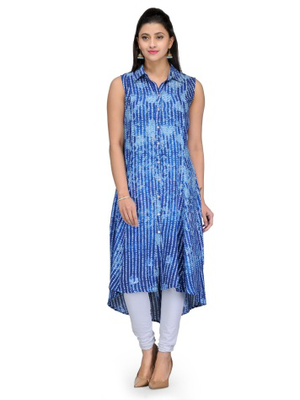

In [64]:
display(IMG.open('../input/images/11145600.jpg').resize((300,400), IMG.ANTIALIAS))

Check out attribute name

In [65]:
print(pa_df['attribute_name'].nunique(), " unique attribute names.")

9  unique attribute names.


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


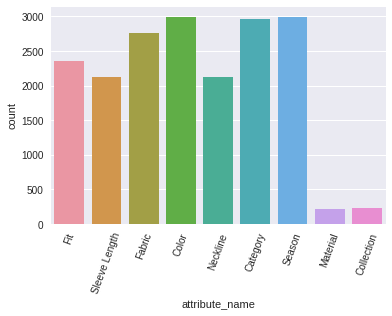

In [66]:
# Distribution of attribute name in product attribute data.
sns.countplot(pa_df['attribute_name'])
plt.xticks(rotation=70)
plt.show()

Let's look at anonymised attribute value 

In [67]:
pa_df['attributevalue'].nunique()

234

Value of attributevalue ranges from 0 to 233.

Maybe we can think of atribute value as a sub category of attribute name. So, we have total 234 type of values, which has 9 groups.

For example, for attribute name 'Color' we have total 131 unique attribute values, so here we have 131 type of color available.

Now for product shirt, it can have many colors, so if it has 2 colors, then we will have have 2 rows. 

shirt | Color | 0

shirt | Color | 2

Here shirt can also have other attributes.

In [68]:
pa_df[['attribute_name', 'attributevalue']].groupby(['attributevalue'])['attribute_name'].nunique()[pa_df[['attribute_name', 'attributevalue']].groupby(['attributevalue'])['attribute_name'].nunique() !=1]

attributevalue
25    2
Name: attribute_name, dtype: int64

It seems like attribute value 2 is connected to 2 attribute names. 

In [69]:
pa_df[['attribute_name', 'attributevalue']].groupby(['attribute_name'])['attributevalue'].nunique().sum()

235

This shows that one attributevalue is related to 2 attribute names.

In [70]:
pa_df[pa_df['attributevalue'] == 25]['attribute_name'].unique()

array(['Color', 'Collection'], dtype=object)

attribute value 25 is related to 'Color' & 'Collection' attribute names.

In [71]:
pa_df[['attribute_name', 'attributevalue']].groupby(['attribute_name'])['attributevalue'].nunique()

attribute_name
Category           5
Collection        21
Color            131
Fabric            33
Fit                6
Material           4
Neckline          12
Season             8
Sleeve Length     15
Name: attributevalue, dtype: int64

We are going to make one hot encode features for both attribute value and attribute name for each product id. Total 243 features.

So, if product id has multiple attribute name, then we are going to put 1 in corresponding one hot position.

In [0]:
pa_df['attributevalue'] = pa_df['attributevalue'].astype('category')

In [0]:
pa_df = pd.concat([pa_df, pd.get_dummies(pa_df[['attribute_name', 'attributevalue']])], axis=1).drop(['attribute_name', 'attributevalue'], axis=1)

now we are going to group by product id and do sum over other columns. 

At last we will have one hot enoded multilable features for each product.

In [0]:
pa_df = pa_df.groupby(['productid']).sum() 

In [100]:
(pa_df > 1).sum().sum()

22

In [0]:
pa_df = pa_df.clip_upper(1)

In [0]:
pa_df.reset_index(inplace=True)

In [103]:
show_all(pa_df.head())

,productid,attribute_name_Category,attribute_name_Collection,attribute_name_Color,attribute_name_Fabric,attribute_name_Fit,attribute_name_Material,attribute_name_Neckline,attribute_name_Season,attribute_name_Sleeve Length,attributevalue_0,attributevalue_1,attributevalue_2,attributevalue_3,attributevalue_4,attributevalue_5,attributevalue_6,attributevalue_7,attributevalue_8,attributevalue_9,attributevalue_10,attributevalue_11,attributevalue_12,attributevalue_13,attributevalue_14,attributevalue_15,attributevalue_16,attributevalue_17,attributevalue_18,attributevalue_19,attributevalue_20,attributevalue_21,attributevalue_22,attributevalue_23,attributevalue_24,attributevalue_25,attributevalue_26,attributevalue_27,attributevalue_28,attributevalue_29,attributevalue_30,attributevalue_31,attributevalue_32,attributevalue_33,attributevalue_34,attributevalue_35,attributevalue_36,attributevalue_37,attributevalue_38,attributevalue_39,attributevalue_40,attributevalue_41,attributevalue_42,attributevalue_43,attributevalue_44,attributevalue_45,attributevalue_46,attributevalue_47,attributevalue_48,attributevalue_49,attributevalue_50,attributevalue_51,attributevalue_52,attributevalue_53,attributevalue_54,attributevalue_55,attributevalue_56,attributevalue_57,attributevalue_58,attributevalue_59,attributevalue_60,attributevalue_61,attributevalue_62,attributevalue_63,attributevalue_64,attributevalue_65,attributevalue_66,attributevalue_67,attributevalue_68,attributevalue_69,attributevalue_70,attributevalue_71,attributevalue_72,attributevalue_73,attributevalue_74,attributevalue_75,attributevalue_76,attributevalue_77,attributevalue_78,attributevalue_79,attributevalue_80,attributevalue_81,attributevalue_82,attributevalue_83,attributevalue_84,attributevalue_85,attributevalue_86,attributevalue_87,attributevalue_88,attributevalue_89,attributevalue_90,attributevalue_91,attributevalue_92,attributevalue_93,attributevalue_94,attributevalue_95,attributevalue_96,attributevalue_97,attributevalue_98,attributevalue_99,attributevalue_100,attributevalue_101,attributevalue_102,attributevalue_103,attributevalue_104,attributevalue_105,attributevalue_106,attributevalue_107,attributevalue_108,attributevalue_109,attributevalue_110,attributevalue_111,attributevalue_112,attributevalue_113,attributevalue_114,attributevalue_115,attributevalue_116,attributevalue_117,attributevalue_118,attributevalue_119,attributevalue_120,attributevalue_121,attributevalue_122,attributevalue_123,attributevalue_124,attributevalue_125,attributevalue_126,attributevalue_127,attributevalue_128,attributevalue_129,attributevalue_130,attributevalue_131,attributevalue_132,attributevalue_133,attributevalue_134,attributevalue_135,attributevalue_136,attributevalue_137,attributevalue_138,attributevalue_139,attributevalue_140,attributevalue_141,attributevalue_142,attributevalue_143,attributevalue_144,attributevalue_145,attributevalue_146,attributevalue_147,attributevalue_148,attributevalue_149,attributevalue_150,attributevalue_151,attributevalue_152,attributevalue_153,attributevalue_154,attributevalue_155,attributevalue_156,attributevalue_157,attributevalue_158,attributevalue_159,attributevalue_160,attributevalue_161,attributevalue_162,attributevalue_163,attributevalue_164,attributevalue_165,attributevalue_166,attributevalue_167,attributevalue_168,attributevalue_169,attributevalue_170,attributevalue_171,attributevalue_172,attributevalue_173,attributevalue_174,attributevalue_175,attributevalue_176,attributevalue_177,attributevalue_178,attributevalue_179,attributevalue_180,attributevalue_181,attributevalue_182,attributevalue_183,attributevalue_184,attributevalue_185,attributevalue_186,attributevalue_187,attributevalue_188,attributevalue_189,attributevalue_190,attributevalue_191,attributevalue_192,attributevalue_193,attributevalue_194,attributevalue_195,attributevalue_196,attributevalue_197,attributevalue_198,attributevalue_199,attributevalue_200,attributevalue_201,attributevalue_202,attributevalue_203,attributeval

In [104]:
pa_df.shape

(3015, 244)

### Train data

In [105]:
train_df['productid'].nunique()

3026

Train data has all 3026 product ids.

In [106]:
train_df['productid'].isin(list(set(imgs_name_productid) - set(pa_df['productid'].unique()))).sum()

192

Total we have 192 records in train dataset which doesn't have attribute features for product id.

UserId

In [107]:
print("Total ", train_df['UserId'].nunique(), " unique users in train data")

Total  27778  unique users in train data


Out of these 27778 users, 2350 users are going to buy 1 or more product in next 2 months.

**So, our task is to forcast which products these customers are going to buy in next month.**

Because we (test data) already know that only 2350 customers are going to buy products, we just have to forcast for these 2350 customers.

Quantity

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


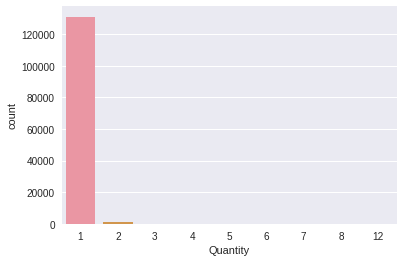

In [108]:
sns.countplot(train_df['Quantity'])
plt.show()

In [109]:
train_df['Quantity'].value_counts()

1     131129
2       1186
3        139
4         56
5         36
8          2
12         1
7          1
6          1
Name: Quantity, dtype: int64

OrderDate

In [0]:
train_df['OrderDate'] = pd.to_datetime(train_df['OrderDate'], dayfirst=True)

In [111]:
train_df.head()

,UserId,productid,Quantity,OrderDate
0,18075,12322648,1,2018-04-01
1,6820,12371370,1,2018-04-01
2,6820,12973004,1,2018-04-01
3,6820,12657560,1,2018-04-01
4,6820,11659914,1,2018-04-01


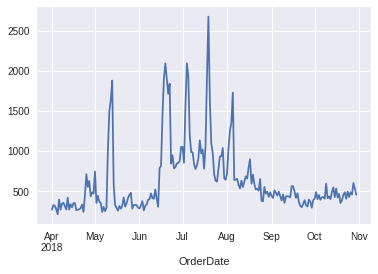

In [112]:
# Number of orders day wise.
train_df.groupby(['OrderDate'])['Quantity'].count().plot()
plt.show()

We have Train data from April 2018 to Oct 2018.

We have to forcast for Nov and Dec, Combined.

In [113]:
train_df['OrderDate'].max()

Timestamp('2018-10-30 00:00:00')

In [114]:
train_df['OrderDate'].min()

Timestamp('2018-04-01 00:00:00')

Try to think of a validation strategy.

In [115]:
train_df[train_df['OrderDate'] > '2018-08-31']['UserId'].nunique()

7086

In [116]:
len(set(train_df[train_df['OrderDate'] <= '2018-08-31']['UserId'].unique()).intersection(set(train_df[train_df['OrderDate'] > '2018-08-31']['UserId'].unique())))

1980

In Septmber and Oct we have 7086 unique users, out of which only 1980 users are existing users. 

### Make features from product images. Use DenseNet121

In [0]:
img_size = 256
batch_size = 16
n_batches = len(imgs_name_productid) // batch_size + 1

In [0]:
def resize_to_square(im):
    old_size = im.shape[:2] # old_size is in (height, width) format
    ratio = float(img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im
  
def load_image(path, product_id):
    image = cv2.imread(f'{path}{product_id}.jpg')
    new_image = resize_to_square(image)
    new_image = preprocess_input(new_image)
    return new_image

In [124]:
inp = Input((256,256,3))
backbone = DenseNet121(input_tensor = inp, include_top = False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Lambda(lambda x: K.expand_dims(x,axis = -1))(x)
x = AveragePooling1D(4)(x)
out = Lambda(lambda x: x[:,:,0])(x)

m = Model(inp,out)

29089792/29084464 [==============================] - 1s 0us/step


In [125]:
img_features = {}
for b in tqdm_notebook(range(n_batches)):
    start = b*batch_size
    end = (b+1)*batch_size
    batch_products = imgs_name_productid[start:end]
    batch_images = np.zeros((len(batch_products),img_size,img_size,3))
    for i, product_id in enumerate(batch_products):
        try:
            batch_images[i] = load_image("../input/images/", product_id)
        except:
            pass
    batch_preds = m.predict(batch_images)
    for i,product_id in enumerate(batch_products):
        img_features[product_id] = batch_preds[i]

In [127]:
len(img_features)

3026

In [0]:
img_features_df = pd.DataFrame.from_dict(img_features, orient='index')

In [0]:
img_features_df = img_features_df.reset_index().rename(columns={'index': 'productid'})

In [133]:
img_features_df.head()

,productid,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
0,12936780,0.002294,0.053471,0.023728,0.016568,0.205274,0.002194,0.008113,0.002574,0.051025,...,0.474683,1.680102,0.782656,0.224010,0.535061,0.895810,1.732252,1.147932,0.685880,0.785485
1,12658116,0.002572,0.090139,0.016815,0.010293,0.123794,0.002296,0.007319,0.002673,0.054563,...,0.732556,0.641507,0.310849,1.080173,0.402177,0.550121,0.402438,1.580256,0.796090,0.110925
2,12657808,0.002924,0.080135,0.035152,0.014036,0.139958,0.002312,0.005795,0.004317,0.054085,...,0.593676,0.789104,0.528445,1.305827,0.368130,1.028803,0.494908,1.750315,0.840000,0.228319
3,11659610,0.002275,0.070190,0.016129,0.014311,0.110492,0.002338,0.007122,0.003976,0.058086,...,0.371726,0.632203,0.656490,1.050406,0.543501,0.394849,0.303732,1.633253,0.628442,0.389560
4,11659018,0.002525,0.057960,0.015884,0.012608,0.119693,0.002683,0.006917,0.003197,0.060223,...,0.155738,0.437230,0.740190,0.680931,0.439998,0.505898,0.434439,2.061210,0.217662,0.322755


In [134]:
del img_features
gc.collect()

55

### Store product attribute and product image features to drive.

In [135]:
pa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3015 entries, 0 to 3014
Columns: 244 entries, productid to attributevalue_233
dtypes: int64(1), uint8(243)
memory usage: 739.1 KB


In [136]:
img_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3026 entries, 0 to 3025
Columns: 257 entries, productid to 255
dtypes: float64(256), int64(1)
memory usage: 5.9 MB


In [0]:
pa_df.to_csv('productid_attr.csv', index=False)

In [0]:
!cp productid_attr.csv ../../drive/ColabNotebooks/AV/capillary-ml-hackathon/

In [0]:
img_features_df.to_csv('img_features_DN121.csv', index=False)

In [0]:
!cp img_features_DN121.csv ../../drive/ColabNotebooks/AV/capillary-ml-hackathon/

In [0]:
pa_df = pd.read_csv('productid_attr.csv')
img_features_df = pd.read_csv('img_features_DN121.csv')

In [22]:
train_df.head()

,UserId,productid,Quantity,OrderDate
0,18075,12322648,1,01/04/18
1,6820,12371370,1,01/04/18
2,6820,12973004,1,01/04/18
3,6820,12657560,1,01/04/18
4,6820,11659914,1,01/04/18


In [20]:
len(set(train_df.groupby(['UserId'])['productid'].nunique()[(train_df.groupby(['UserId'])['productid'].nunique() == 1)].index.values).intersection(set(test_df['UserId'].values)))

719

719 users in test data has bought only one product so far.